In [1]:
import os
import json
import pickle
import numpy as np
import glob
import random 
import itertools
import datetime
from datetime import timezone

from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt
from platform import python_version

from scipy.stats import norm
from scipy.optimize import leastsq
import seaborn as sns

print(python_version())

import sys
sys.path.append("..")

3.7.3


In [2]:
#!pip install fasttext

In [3]:
#!pip install seaborn

In [4]:
from source.utils_npa import get_dpg_data_processed

In [10]:
data_set = "medium"

data_path = "../datasets/dpg/" + data_set + "_time_split_most_common/"
news_file = data_path + 'news_data.pkl'
user_file = data_path + 'user_data.pkl'

In [9]:
os.listdir(data_path)

['news_data.pkl',
 'user_data.pkl',
 'data_prepped_wu.pkl',
 'logging_dates.json',
 'news_prepped_wu.pkl']

In [317]:
os.listdir("../evaluation/")

['data_analysis_dpg.ipynb', '.ipynb_checkpoints', 'medium']

In [318]:
eval_dir = "../evaluation/" + data_set + "/"
os.makedirs(eval_dir, exist_ok=True)

In [319]:
## load data
with open(news_file, 'rb') as fin:
    news_data = pickle.load(fin)
    
with open(user_file, "rb") as fin:
    user_data = pickle.load(fin)

log_file = "/".join(user_file.split("/")[:-1]) + '/logging_dates.json'
with open(log_file, 'r') as fin:
    logging_dates = json.load(fin)

# determine start of the test interval in UNIX time
if "threshold" in logging_dates.keys():
    start_test_interval = logging_dates['threshold']

In [320]:
#next(iter(news_data['all'].items()))

In [321]:
news_df = pd.DataFrame.from_dict(news_data['all'], orient='index')
news_df = news_df.drop(['author', 'snippet'], axis=1)
news_df.head()

,text,pub_date,n_words
127793a,Maarten Dallinga maakte succesvolle podcast ov...,2019-12-08T18:05:50.553Z,883
4f3c046,Fietsen getest: Dit zijn de beste (elektrische...,None,1696
575246e,Dankzij Zederik en Leerdam is Utrecht economis...,2019-12-17T15:28:55.893Z,265
5a8c8b0,5 lastminutetips van een styliste als je nog t...,2019-12-31T15:57:18.740Z,196
b6648d9,Noord-Korea wil medische behandelingen voor to...,2019-12-06T12:48:00.000Z,184


In [322]:
news_train = pd.DataFrame.from_dict(news_data['train'])
news_test = pd.DataFrame.from_dict(news_data['test'])

In [323]:
next(iter(user_data.items()))

('001eb194-12f9-40ed-99d8-4a3788585961',
 {'articles_read': [['ad', '746bf4b', 1575978568],
   ['ad', 'ea91d1e', 1576599678],
   ['ad', 'cb0886d', 1576759596],
   ['ad', '19aa145', 1576853290],
   ['ad', 'd837e0a', 1576854944],
   ['ad', '776e1a3', 1576876970],
   ['ad', '82428df', 1576935433],
   ['ad', '3ec3bb9', 1576955333],
   ['ad', 'e41d509', 1577294714],
   ['ad', '341ed7b', 1577370080],
   ['ad', '1580bc3', 1577542224],
   ['ad', '341ed7b', 1577542224],
   ['ad', '2adde35', 1577754349]],
  'opened_pushes': [],
  'articles_pushed': [],
  'articles_train': [['ad', '19aa145', 1576853290],
   ['ad', 'd837e0a', 1576854944],
   ['ad', '776e1a3', 1576876970],
   ['ad', 'ea91d1e', 1576599678],
   ['ad', 'cb0886d', 1576759596],
   ['ad', '82428df', 1576935433],
   ['ad', '3ec3bb9', 1576955333],
   ['ad', '746bf4b', 1575978568]],
  'articles_test': [['ad', '341ed7b', 1577370080],
   ['ad', 'e41d509', 1577294714],
   ['ad', '2adde35', 1577754349],
   ['ad', '1580bc3', 1577542224],
   ['ad

In [324]:
user_df = pd.DataFrame.from_dict(user_data, orient='index')
user_df = user_df.drop(['opened_pushes', 'articles_pushed'], axis=1)
user_df.head()

,articles_read,articles_train,articles_test,n_arts_read
001eb194-12f9-40ed-99d8-4a3788585961,"[[ad, 746bf4b, 1575978568], [ad, ea91d1e, 1576...","[[ad, 19aa145, 1576853290], [ad, d837e0a, 1576...","[[ad, 341ed7b, 1577370080], [ad, e41d509, 1577...",13
002c6eaf-f12d-4536-8bfc-9313c84c7759,"[[None, 1d21600, 1575294200], [None, 7e4cb62, ...","[[None, a78da5d, 1576585653], [None, 16bd4d1, ...",[],17
002cc435-31cd-4d1a-ac2d-80624f453559,"[[hln, 23865a8, 1575219800], [hln, 4c64e9d, 15...","[[hln, daba7bf, 1575479893], [hln, 79a7409, 15...",[],19
0057733f-3914-4185-ab5b-443fff7ed386,"[[ad, a295cf1, 1575234063], [ad, 349118f, 1575...","[[ad, 76f088a, 1577200791], [ad, 0dc1a64, 1577...","[[ad, 11d63bc, 1577445823], [ad, 82428df, 1577...",171
006ee30d-309d-4ba4-8d5f-053ed98839e9,"[[hln, b879684, 1575201849], [hln, 90bce99, 15...","[[hln, 5e8f374, 1575902299], [hln, db11cfe, 15...",[],47


## Data Sparsity

How many articles in our subset of all articles are actually read? How many of those during the train and test interval?

In [325]:
n_total_arts = len(news_data['all'])
n_total_read = len(news_data['train']) + len(news_data['test'])

data_info = []
data_info.append("Articles in {} item subset: {}".format(data_set, n_total_arts))
data_info.append("Users in {} subset: {}".format(data_set, len(user_data)))
data_info.append("Proportion of read articles: {:.1f}% ({}/{})".format(n_total_read/n_total_arts*100, n_total_read, n_total_arts))
data_info.append("Read Articles \t Train: {} \t Test: {}".format(len(news_data['train']), len(news_data['test'])))

    
with open(eval_dir + "data_info.txt", 'w') as fout:
    for line in data_info: 
        fout.write(line)
        fout.write("\n")
        print(line)

Articles in medium item subset: 39350
Users in medium subset: 10000
Proportion of read articles: 84.3% (33184/39350)
Read Articles 	 Train: 26007 	 Test: 7177


In [326]:
sns.set()

## Number of Articles read per User

Text(0, 0.5, 'Proportion of articles')

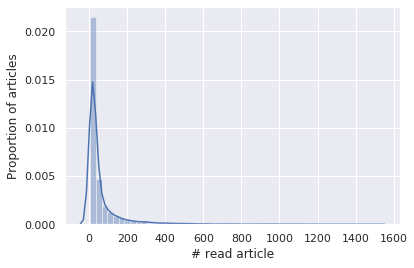

In [327]:
sns.distplot(user_df['n_arts_read'])
plt.xlabel("# read article")
plt.ylabel("Proportion of articles")

(array([0.0295509 , 0.00928489, 0.00439577, 0.00220066, 0.0017572 ,
        0.00135809, 0.00098115, 0.00089246, 0.0006153 , 0.00050998]),
 array([  5. ,  24.4,  43.8,  63.2,  82.6, 102. , 121.4, 140.8, 160.2,
        179.6, 199. ]),
 <a list of 10 Patch objects>)

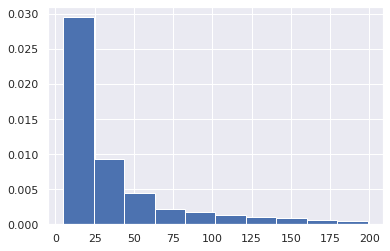

In [328]:
data = user_df[user_df['n_arts_read'] < 200]['n_arts_read']

plt.hist(data, density=True)

In [329]:
def hist_with_mean(data, bins=range(4,150,4), density=True, cumulative=False, cum_thresh=None):
    n, bins, patches = plt.hist(data, bins=bins, density=density, cumulative=cumulative)
    plt.axvline(data.mean(), color='orange', linestyle='--', label='mean')
    plt.axvline(data.median(), color='g', linestyle='--', label='median')
    if cumulative and cum_thresh is not None:
        plt.axhline(cum_thresh, color='r', linestyle='-', alpha=0.7)

    plt.xlabel('# reads per user')
    plt.ylabel('Proportion')
    plt.title('Distribution of total # reads per user on {} set'.format(data_set))

    plt.legend()

    print("Mean: %.1f" % data.mean())
    print("Median: %.f" % data.median())
    print("Max: %.f" % data.max())
    print("Std: %.1f" % data.std())
    return n, bins, patches

Mean: 60.9
Median: 22
Max: 1501
Std: 108.5


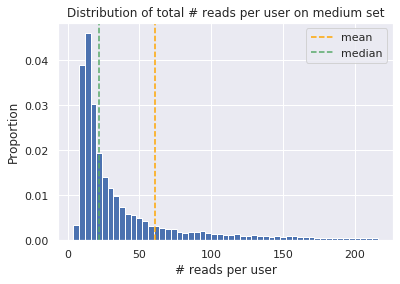

In [330]:
hist_with_mean(user_df['n_arts_read'], bins=range(4,220,4), cumulative=False)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_all.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Mean: 60.9
Median: 22
Max: 1501
Std: 108.5


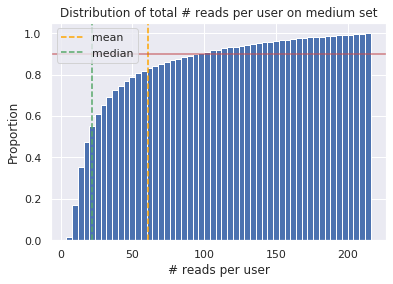

In [331]:
n, bins, patches = hist_with_mean(user_df['n_arts_read'], bins=range(4,220,4), cumulative=True, cum_thresh=0.9)
fname=eval_dir + data_set + "_n_reads_user_cum_hist.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

In [332]:
thresh = 0.9
total = 0
for i, prob in enumerate(n):
    if prob > thresh:
        print(i)
        print(bins[i])
        break

23
96


Mean: 36.8
Median: 21
Max: 200
Std: 38.4


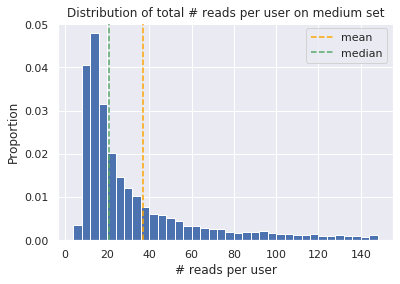

In [333]:
n_max=200

hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=False)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Mean: 52.3
Median: 22
Max: 498
Std: 75.4


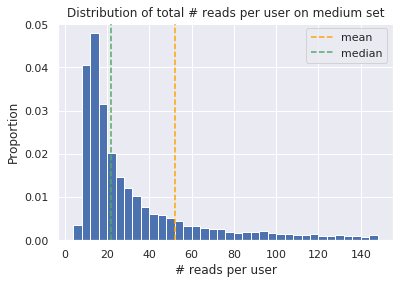

In [334]:
n_max=500

hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=False)
# fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)
fname=eval_dir + data_set + "_n_reads_user_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Mean: 36.8
Median: 21
Max: 200
Std: 38.4


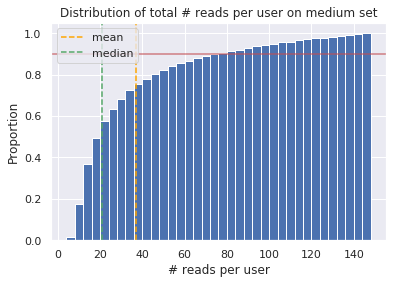

In [335]:
n_max=200
hist_with_mean(user_df[user_df['n_arts_read'] < n_max+1]['n_arts_read'], cumulative=True, cum_thresh=0.9)
fname=eval_dir + data_set + "_n_reads_user_cum_hist_"+str(n_max)+".png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

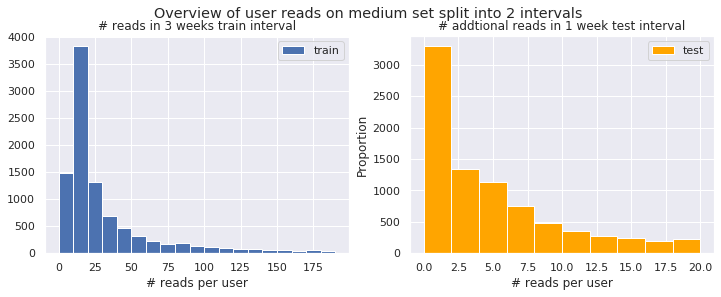

In [377]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

ax1.hist(user_df['articles_train'].apply(len), bins=range(0,200,10), density=False, label='train')
ax1.title.set_text("# reads in 3 weeks train interval")
plt.ylabel('Proportion')

ax2.hist(user_df['articles_test'].apply(len), bins=range(0,22,2), density=False, color='orange', label='test')
ax2.title.set_text("# addtional reads in 1 week test interval")

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('# reads per user')

plt.suptitle('Overview of user reads on {} set split into 2 intervals'.format(data_set))
plt.show()

## Words per Article

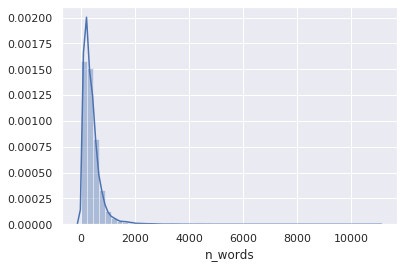

In [337]:
sns.distplot(news_df['n_words'])

Max: 10996
Min: 1
Mean: 398
Median: 308
Std: 362.8


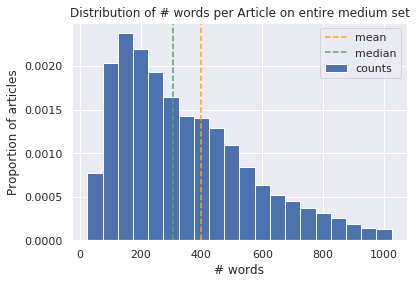

In [338]:
#
bins=range(25,1050,50)
plt.hist(news_df['n_words'], bins=bins, density=True, label='counts')


(mu, sigma) = norm.fit(news_df['n_words'])
y = norm.pdf(bins, mu, sigma)
plt.axvline(mu, color='orange', linestyle='--', label='mean')
plt.axvline(news_df['n_words'].median(), color='g', linestyle='--', label='median')
#plt.plot(bins, y, 'r--')

plt.xlabel('# words')
plt.ylabel('Proportion of articles')
plt.title('Distribution of # words per Article on entire {} set'.format(data_set))

plt.legend()

print("Max: %.f" % news_df['n_words'].max())
print("Min: %.f" % news_df['n_words'].min())
print("Mean: %.f" % news_df['n_words'].mean())
print("Median: %.f" % news_df['n_words'].median())
print("Std: %.1f" % news_df['n_words'].std())

fname=eval_dir + data_set + "_n_words_all_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

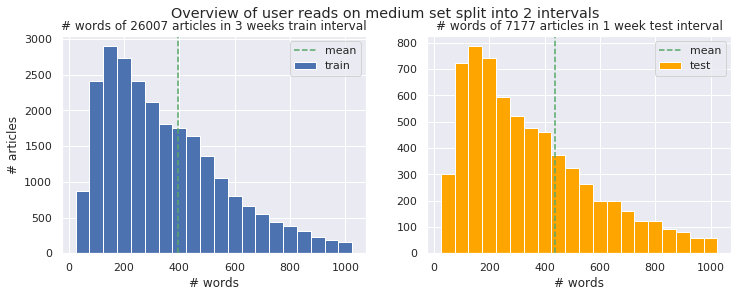

<Figure size 432x288 with 0 Axes>

In [380]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

ax1.hist(news_df.loc[news_data['train']]['n_words'], bins=bins, density=False, label='train')
ax1.axvline(news_df.loc[news_data['train']]['n_words'].mean(), color='g', linestyle='--', label='mean')
ax1.title.set_text("# words of {} articles in 3 weeks train interval".format(len(news_df.loc[news_data['train']])))
ax1.set_ylabel('# articles')

ax2.hist(news_df.loc[news_data['test']]['n_words'], bins=bins, density=False, color='orange', label='test')
ax2.axvline(news_df.loc[news_data['test']]['n_words'].mean(), color='g', linestyle='--', label='mean')
ax2.title.set_text("# words of {} articles in 1 week test interval".format(len(news_df.loc[news_data['test']])))

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel('# words')

plt.suptitle('Overview of user reads on {} set split into 2 intervals'.format(data_set))
plt.show()

fname=eval_dir + data_set + "_n_words_traintest_dec19.png"
plt.savefig(fname, dpi=400)

In [340]:
'''
create buckets for different time intervals 
iterate through each 'article_read' for all users
assign article to bucket depending on 'time_stamp'
plot buckets as histogram
'''

"\ncreate buckets for different time intervals \niterate through each 'article_read' for all users\nassign article to bucket depending on 'time_stamp'\nplot buckets as histogram\n"

In [341]:
import datetime
from datetime import timezone, timedelta

In [342]:
datetime.datetime(2019, 12, 1, 23, 59, 59).strftime('%s')

'1575241199'

In [343]:
t1 = datetime.datetime(2019, 12, 1, 23, 59, 59)

In [344]:
t2 = datetime.datetime(2019, 12, 24, 23, 59, 59)

In [345]:
delta = (t1 - t2)
delta

datetime.timedelta(days=-23)

In [346]:
delta.total_seconds() / (60*60*24)

-23.0

In [347]:
datetime.datetime.utcfromtimestamp(int('1577228399')).strftime('%Y-%m-%d %H:%M:%S')

'2019-12-24 22:59:59'

In [348]:
datetime.datetime.fromtimestamp(int('1577228399'))

datetime.datetime(2019, 12, 24, 23, 59, 59)

In [349]:
t2 < t1

False

In [350]:
def counts_per_bucket(user_data, buckets=range(1,32), scale='day', normalise=False):
    reads_per_bucket = defaultdict(int)
    
    #smallest_t=None
    
    for u_id in user_data:
        _, art_ids, time_stamps = zip(*user_data[u_id]['articles_read'])
        for time_stamp in time_stamps:
            for bucket in buckets:
                t = datetime.datetime.fromtimestamp(time_stamp)
                if 'hour' == scale:
                    if t.hour==bucket and bucket != 0:
                        reads_per_bucket[bucket] += 1
                        break
                    elif bucket==0 and t.hour==buckets[-1]:
                        reads_per_bucket[bucket] += 1
                        break
                    
                elif 'day'==scale and t.day == bucket:
                    reads_per_bucket[bucket] += 1
                    break
                
                elif 'week'==scale and t.day/7 < bucket:
                    reads_per_bucket[bucket] += 1
                    break
                    
    #print("Earliest time: {}, {}".format(datetime.datetime.fromtimestamp(smallest_dt).strftime('%A'), 
    #                                     datetime.datetime.fromtimestamp(smallest_dt)))
    x, y = zip(*sorted(reads_per_bucket.items()))
    
    if normalise:
        y = [val/len(user_data) for val in y]
    
    return x, y

In [351]:
def counts_per_interval_buckets(user_data, intervals : dict, plot=True, in_plot1=["morning", "noon", "afternoon"], 
                               ylim=[0,1000], sharey=False):
    out_dict = {key: defaultdict(int) for key in intervals.keys()}

    for u_id in user_data:
        _, art_ids, time_stamps = zip(*user_data[u_id]['articles_read'])
        for time_stamp in time_stamps:
            hour = datetime.datetime.fromtimestamp(time_stamp).hour
            minute = datetime.datetime.fromtimestamp(time_stamp).minute
            day = datetime.datetime.fromtimestamp(time_stamp).day

            for key, interval in daytime_intervals.items():
                if interval[0] <= hour <= interval[1]:
                    out_dict[key][day] += 1
                    break
                elif "night" == key:
                    if interval[0] <= hour or hour <= interval[1]:
                        out_dict[key][day] += 1
                        break
    if plot:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=sharey, figsize=(12,4))

        for daytime, reads_per_day in out_dict.items():
            x, y = zip(*sorted(reads_per_day.items()))
            if daytime in in_plot1:
                ax1.plot(x, y, label=daytime)
            else:
                ax2.plot(x, y, label=daytime)
        
        plt.xlabel("Day")
        ax1.set_ylabel("# articles read")
        ax1.legend()
        ax2.legend()
        if ylim is not None:
            plt.ylim(ylim)

    return out_dict

## Reading behaviour over Time

Users: 10000


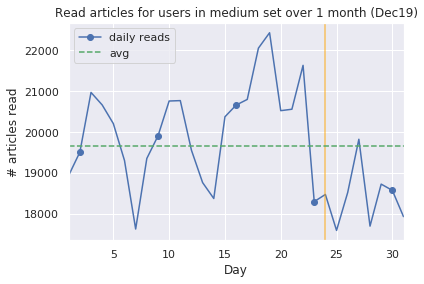

In [352]:
x, y = counts_per_bucket(user_data, buckets=range(1,32), scale='day')

plt.plot(x, y, label="daily reads", marker='o',markevery=range(1,32,7))
plt.axvline(24, color='orange', linestyle='-', alpha=0.6)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Day")
plt.ylabel("# articles read")
plt.title("Read articles for users in {} set over 1 month (Dec19)".format(data_set))
#plt.ylim([0, 2000])
plt.xlim([1,31])
plt.legend()
print("Users: {}".format(len(user_data)))

fname=eval_dir + data_set + "_n_reads_daily_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Interaction ratio of 1 means that each user reads 1 article per day


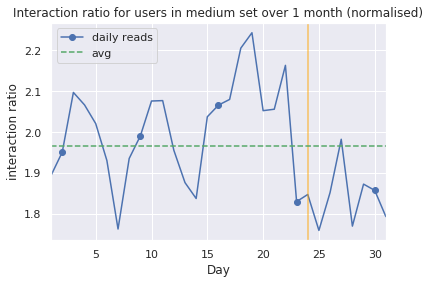

In [353]:
x, y = counts_per_bucket(user_data, buckets=range(1,32), scale='day', normalise=True)

plt.plot(x, y, label="daily reads", marker='o',markevery=range(1,31,7))
plt.axvline(24, color='orange', linestyle='-', alpha=0.6)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Day")
plt.ylabel("interaction ratio")
plt.title("Interaction ratio for users in {} set over 1 month (normalised)".format(data_set))
#plt.ylim([0, 2000])
plt.xlim([1,31])
plt.legend()
print("Interaction ratio of 1 means that each user reads 1 article per day")

fname=eval_dir + data_set + "_read_ratio_daily_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Peak at 9:
Low at 3:


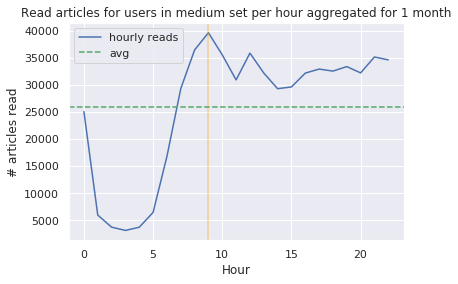

In [354]:
x, y = counts_per_bucket(user_data, buckets=range(0,24), scale='hour')
plt.plot(x, y, label="hourly reads")
plt.axvline(9, color='orange', linestyle='-', alpha=0.4)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Hour")
plt.ylabel("# articles read")
plt.title("Read articles for users in {} set per hour aggregated for 1 month".format(data_set))
#plt.ylim([0, 2000])

plt.legend()
print("Peak at {}:".format(np.argmax(y)))
print("Low at {}:".format(np.argmin(y)))

fname=eval_dir + data_set + "_n_reads_24h_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

Peak at 9:
Low at 3:


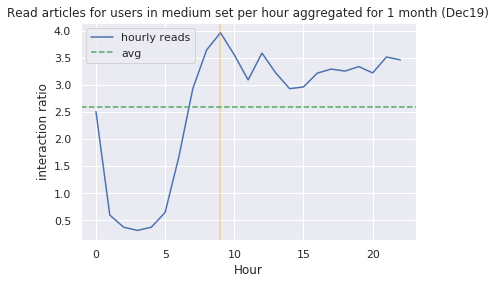

In [355]:
x, y = counts_per_bucket(user_data, buckets=range(0,24), scale='hour', normalise=True)
plt.plot(x, y, label="hourly reads")
plt.axvline(9, color='orange', linestyle='-', alpha=0.4)
plt.axhline(np.mean(y), color='g', linestyle='--', label="avg")
plt.xlabel("Hour")
plt.ylabel("interaction ratio")
plt.title("Read articles for users in {} set per hour aggregated for 1 month (Dec19)".format(data_set))
#plt.ylim([0, 2000])

plt.legend()
print("Peak at {}:".format(np.argmax(y)))
print("Low at {}:".format(np.argmin(y)))

fname=eval_dir + data_set + "_read_ratio_24h_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

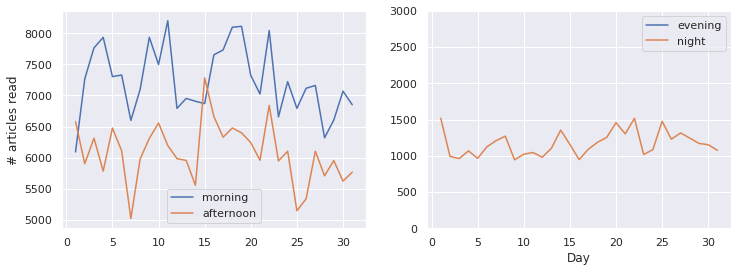

In [356]:
daytime_intervals = {
    "morning": (6,12),
    "afternoon": (12, 18),
    "evening": (18, 23),
    "night": (23,6),
}

out_dict = counts_per_interval_buckets(user_data, daytime_intervals, ylim=[0,3000])

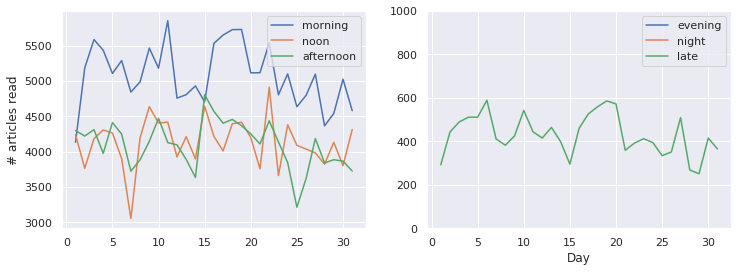

In [357]:
daytime_intervals = {
    "morning": (6,10),
    "noon": (10, 14),
    "afternoon": (14, 18),
    "evening": (18, 22),
    "night": (22,2),
    "late": (2, 6)
}

out_dict = counts_per_interval_buckets(user_data, daytime_intervals)

In [358]:
t1 = datetime.datetime.fromtimestamp(1575806402)
print(datetime.datetime.fromtimestamp(1575806402).strftime('%Y-%m-%d %H:%M:%S'))
print("Day {}, Hour {}, Minute {}".format(t1.day, t1.hour, t1.minute))

t2 = datetime.datetime(2019,12,1,0,10,50)
print("Day {}, Hour {}, Minute {}".format(t2.day, t2.hour, t2.minute))

2019-12-08 13:00:02
Day 8, Hour 13, Minute 0
Day 1, Hour 0, Minute 10


In [359]:
t2 - t1

datetime.timedelta(days=-8, seconds=40248)

In [360]:
t1 - t2

datetime.timedelta(days=7, seconds=46152)

In [361]:
(t1-t2).total_seconds()

650952.0

In [362]:
def timedeltas_in_buckets(user_data, resolution="minutes"):
    delta_dist = []
    for u_id in user_data:
        arts = user_data[u_id]['articles_read']
        _, _, time_stamps = zip(*arts)
        for i, time_stamp in enumerate(sorted(time_stamps)):
            if i != 0: 
                delta = datetime.datetime.fromtimestamp(time_stamp) - prev_stamp
                
                if delta.total_seconds() < 0:
                    print(time_stamps)
                    break
                
                if "minutes" == resolution:
                    delta = delta.total_seconds()/60
                elif "seconds" == resolution:
                    delta = delta.total_seconds()
                elif "hours" == resolution:
                    delta = delta.total_seconds()/ (60*60)
                else:
                    raise NotImplemented()
                
                delta_dist.append(delta)
                
            prev_stamp = datetime.datetime.fromtimestamp(time_stamp)
            
    return delta_dist

In [382]:
deltas = timedeltas_in_buckets(user_data, resolution="minutes")

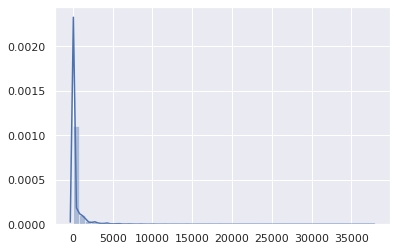

In [383]:
sns.distplot(deltas)

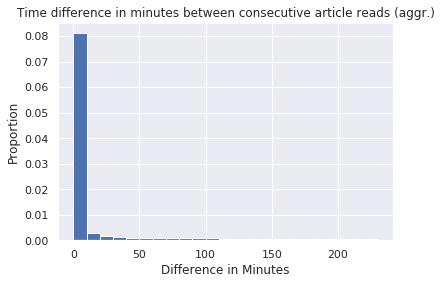

In [385]:
plt.hist(deltas, bins=range(0,240,10), density=True)
plt.xlabel("Difference in Minutes")
plt.ylabel("Proportion")
plt.title("Time difference in minutes between consecutive article reads (aggr.)")

fname=eval_dir + data_set + "_timedif_reads_240min_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

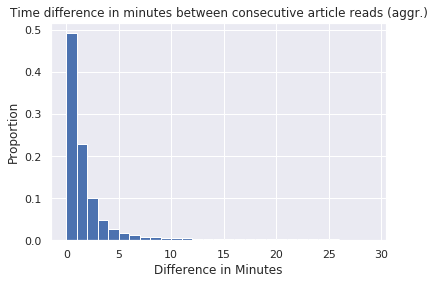

In [366]:
#deltas_filt = [delta for delta in deltas if delta<50]
plt.hist(deltas, bins=range(0,30,1), density=True)
plt.xlabel("Difference in Minutes")
plt.ylabel("Proportion")
plt.title("Time difference in minutes between consecutive article reads (aggr.)")

fname=eval_dir + data_set + "_timedif_reads_30min_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

In [367]:
# first & last read - just one session? multiple reads per day / week 
# given history of N articles, how many session are this? -> cluster by time
# towards session awareness? build test set with specific users to evaluate the model capacity

In [368]:
# current time for when to make a recommendation
# potential overfit on recency?


In [369]:
'''
sample N users with a hist_length > l
compute time_delta between consecutive reads
plot procession of those delta 
x: position in history
y: time delta

expect: session transitions show high time delta, i.e. large time difference between two reads

'''

'\nsample N users with a hist_length > l\ncompute time_delta between consecutive reads\nplot procession of those delta \nx: position in history\ny: time delta\n\nexpect: session transitions show high time delta, i.e. large time difference between two reads\n\n'

In [370]:
def timedeltas_per_user(user_data, resolution="minutes"):
    delta_dist = defaultdict(list)
    
    for u_id in user_data:
        arts = user_data[u_id]['articles_read']
        _, _, time_stamps = zip(*arts)
        for i, time_stamp in enumerate(sorted(time_stamps)):
            if i != 0: 
                delta = datetime.datetime.fromtimestamp(time_stamp) - prev_stamp
                
                if delta.total_seconds() < 0:
                    print(time_stamps)
                    break
                
                if "minutes" == resolution:
                    delta = delta.total_seconds()/60
                elif "seconds" == resolution:
                    delta = delta.total_seconds()
                elif "hours" == resolution:
                    delta = delta.total_seconds()/ (60*60)
                else:
                    raise NotImplemented()
                
                delta_dist[u_id].append(delta)
                
            prev_stamp = datetime.datetime.fromtimestamp(time_stamp)
            
    return delta_dist

In [371]:
N = 10
min_hist_len = 40

subset = {}
while len(subset) < N:
    u_id = random.choice(list(user_data.keys()))
    if u_id not in subset and user_data[u_id]['n_arts_read'] >= min_hist_len:
        subset[u_id] = user_data[u_id]

#subset = {u_id: user_data[u_id] for u_id in u_sample}

In [409]:
deltas = timedeltas_per_user(subset, resolution="minutes")

Text(0, 0.5, 'Time delta [min]')

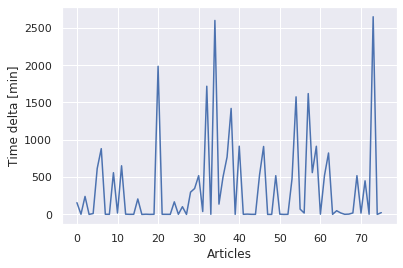

In [399]:
plt.plot(next(iter(deltas.values())))
plt.xlabel("Articles")
plt.ylabel("Time delta [min]")

In [400]:
next(iter(axs))

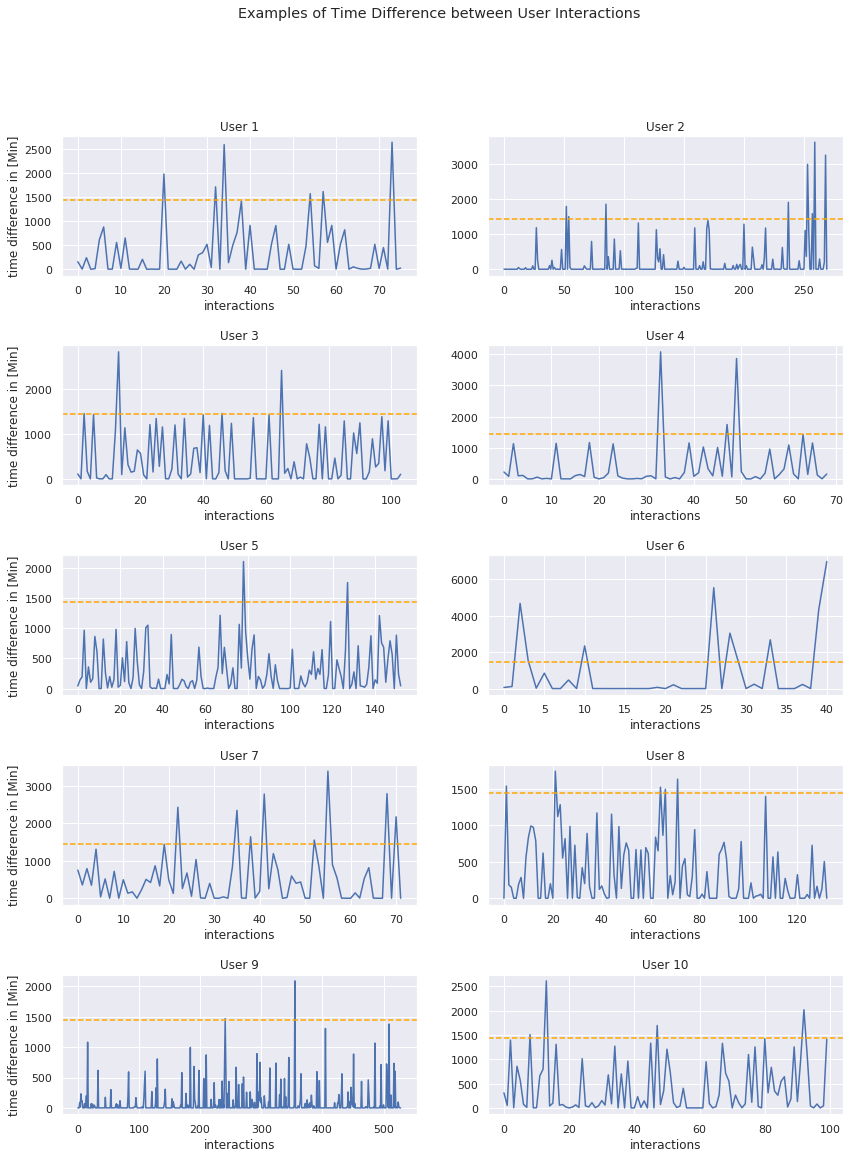

<Figure size 432x288 with 0 Axes>

In [401]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,18))
#keep_u = [0,1,3,5,6,9]
axs = list(itertools.chain(*axs))
#assert len(axs) == len(deltas)
for i, u_id in enumerate(deltas):
    
    axs[i].plot(deltas[u_id], label=u_id)
    axs[i].axhline(60*24, color='orange', linestyle='--', label='24h')

    axs[i].set_xlabel("interactions")
    if i % 2 == 0:
        axs[i].set_ylabel("time difference in [Min]")
    axs[i].title.set_text("User {}".format(i+1))
    #axs[i].set_yscale('logit')
    
plt.suptitle('Examples of Time Difference between User Interactions')
plt.subplots_adjust(hspace = 0.5)
plt.show()

fname=eval_dir + data_set + "_timedif_reads_n10_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')

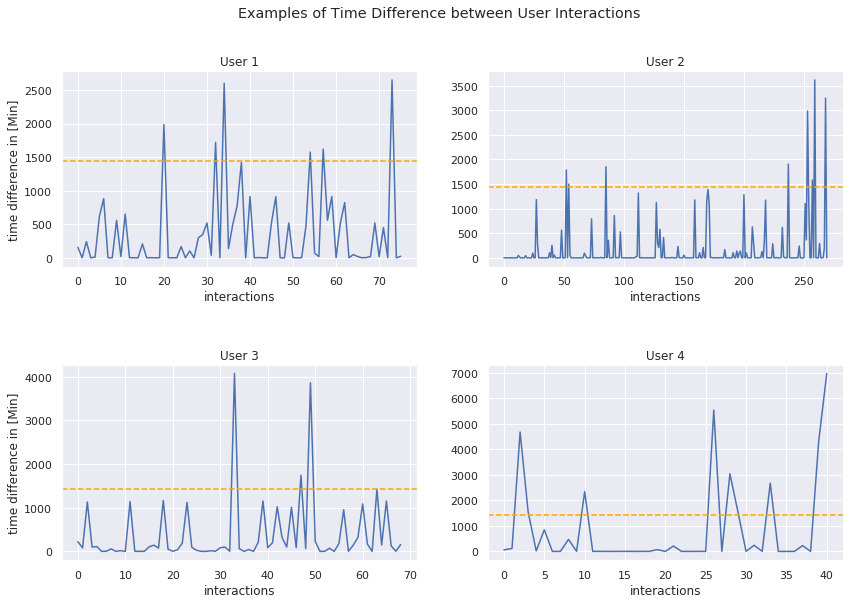

<Figure size 432x288 with 0 Axes>

In [410]:
keep_u = [0,1,3,5]
deltas = {u_id: deltas[u_id] for i, u_id in enumerate(deltas) if i in keep_u}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

axs = list(itertools.chain(*axs))
#assert len(axs) == len(deltas)
for i, u_id in enumerate(deltas):
    
    axs[i].plot(deltas[u_id], label=u_id)
    axs[i].axhline(60*24, color='orange', linestyle='--', label='24h')

    axs[i].set_xlabel("interactions")
    if i % 2 == 0:
        axs[i].set_ylabel("time difference in [Min]")
    axs[i].title.set_text("User {}".format(i+1))
    #axs[i].set_yscale('logit')
    
plt.suptitle('Examples of Time Difference between User Interactions')
plt.subplots_adjust(hspace = 0.5)
plt.show()

fname=eval_dir + data_set + "_timedif_reads_n10_dec19.png"
plt.savefig(fname, dpi=400, bbox_inches='tight')